### How to use this notebook (for anyone not familiar with jupyter)

Before we get started, I'd like to note that while reading this notebook on github is fine, there are several interactive elements used to demonstrate several ideas that only render when the notebook is ran in a live kernel. This also allows you to play with the code samples inline with the rest of the notebook.

For the best experience I'd recommend installing [jupyter](https://jupyter.org/install) on your machine and cloning this repository so that you can run the notebooks locally. 

If however you'd prefer not to install anything, you can also run this notebook on Google's Colab [here](https://colab.research.google.com/github/jd-13/dsp-math-for-audio/blob/master/01_Digital-IIR-Filters.ipynb).

Once running click `Kernel` -> `Restart & Run All` (or `Runtime` -> `Run all` if you're using Colab) to render all of the interactive examples, and you are then free to edit the code and run individual cells as you wish.

In [1]:
# This cell contains imports, variables, and functions required by code later in the notebook

from ipywidgets import interact
import matplotlib.pylab as plt
import numpy as np
import scipy.signal
%matplotlib inline

## Intro

In this notebook we'll be looking at the background and the mathematical implementation of several classes of filters which fall under the category of digital IIR filters. What this means isn't too important right now, but these are types of filters which are often based on analogue filters and have been converted into their digital equivalents. They are commonly used in digital audio processing, as well as control systems and other applications.

The ultimate aim here is to go from knowing little to nothing about IIR Filters, to knowing the bare minimum math required to be able to design and implement filters in Python, C++, or any similar language.

We'll start with some background such as how to describe a particular filter, and what is important about the behaviour of a filter. Then we'll look a some math and finally how to actually implement this in code.

So what does a filter actually do? A filter is normally designed to remove particular frequencies from a signal, whether this is in some form of audio equalizer or a control system.

The below code sample demonstrates the use of filters that have already been built for us in the scipy package. Run the code and the controls and output will be drawn inline below it. You can drag the sliders and change the type and class of the filter to explore how these parameters affect the processing the filter does to an input signal.

You don't need to understand how any of the code works yet, and what these parameters mean will be described in the next section.

In [2]:
@interact(cutoff=(0.005, 9.9, 1), bandType=["lowpass", "highpass"], filterClass=["butterworth", "chebyshev1", "chebyshev2", "elliptic", "bessel"], order=(1, 10, 1))
def filterBuffer(cutoff, bandType, filterClass, order):
    # Build our sine signal
    NUM_SAMPLES = 200
    SAMPLE_RATE = 44100
    sampleRange = np.linspace(0, 4 * np.pi, NUM_SAMPLES)
    buffer = np.sin(sampleRange) + np.sin(5 * sampleRange) + np.sin(20 * sampleRange)

    plt.figure(figsize=(15, 3))
    
    # Plot the input signal
    plt.subplot(1, 3, 1)
    plt.plot(sampleRange, buffer)
    plt.ylim(bottom=-3, top=3)
    plt.title("Filter Input")
    plt.xlabel("Samples")
    plt.ylabel("Displacement")

    # Calculate the coefficients of a Butterworth filter for the given cutoff
    # and apply the filtering
    if filterClass == "butterworth":
        b, a = scipy.signal.butter(order, cutoff / 10.0, btype=bandType, analog=False)
    elif filterClass == "chebyshev1":
        b, a = scipy.signal.cheby1(order, 0.5, cutoff / 10.0, btype=bandType, analog=False)
    elif filterClass == "chebyshev2":
        b, a = scipy.signal.cheby2(order, 20, cutoff / 10.0, btype=bandType, analog=False)
    elif filterClass == "elliptic":
        b, a = scipy.signal.ellip(order, 0.5, 20, cutoff / 10.0, btype=bandType, analog=False)
    elif filterClass == "bessel":
        b, a = scipy.signal.bessel(order, cutoff / 10.0, btype=bandType, analog=False)
    
    buffer = scipy.signal.lfilter(b, a, buffer)
    
    # Calculate our frequency response
    angularFreq, response = scipy.signal.freqz(b, a, worN=8000)

    # Plot output and frequency response
    plt.subplot(1, 3, 2)
    plt.plot(0.5 * SAMPLE_RATE * angularFreq / np.pi, np.abs(response))
    plt.xlim(0, 0.5 * SAMPLE_RATE)
    plt.title("Filter Frequency Response")
    plt.xlabel("Frequency (Hz)")

    plt.subplot(1, 3, 3)
    plt.plot(sampleRange, buffer)
    plt.ylim(bottom=-3, top=3)
    plt.title("Filter Output")
    plt.xlabel("Samples")
    plt.ylabel("Displacement")
    
    plt.show()

interactive(children=(FloatSlider(value=4.005, description='cutoff', max=9.9, min=0.005, step=1.0), Dropdown(description='bandType', options=('lowpass', 'highpass'), value='lowpass'), Dropdown(description='filterClass', options=('butterworth', 'chebyshev1', 'chebyshev2', 'elliptic', 'bessel'), value='butterworth'), IntSlider(value=5, description='order', max=10, min=1), Output()), _dom_classes=('widget-interact',))

In lowpass mode you'll notice that as you lower the cutoff frequency, more of the high and mid range frequencies are removed, until only the lowest remain. In highpass mode, the opposite occurs.



## Characteristics of a filter

A theme you might notice when working on filter design is that it is often an exercise in comparing tradeoffs and making decisions about which characteristic is most important to your application. You're unlikely to find a filter that perfectly fits what you're trying to achive, and will probably have to make compromises and design decisions to get as close a possible to your goals.

After reading through the characteristics below, it may be useful to revisit the above interactive example to help visualise the behaviours of different filters.

### Cutoff frequency and bands
One of the key characteristics of a filter is its cutoff frequency. This is defined as the point somewhere between the filter's passband (the frequency range which is passed through the filter) and the filter's stopband (the frequency range which is attenuated by the filter), where the attenuation of the frequencies is -3dB.

Because it is difficult to produce a filter with a sharp transition between the passband and stopband, there is a slope is this region as the frequencies become more attenuated as they approach the stopband.

Where these passbands or stopbands are, depends on the type of filter:
- __Low-pass (or high cut)__: passband is below the cutoff, stopband is above
- __High-pass (or low cut)__: stopband is below the cutoff, passband is above
- __Band-pass__: passband is between two cutoff frequencies, with stopband being everything above and below this range.

### Group delay and phase delay
A filter may impart a time delay on the amplitude of the signal it is processing, and the size of this delay may be dependant on the frequency of the signal. This characteristic is known as __group delay__.

Similarly, a filter may also impart a time delay on the phase of the signal it is processing, where the size of this delay may also be dependant on the frequency of the signal. This characteristic is known as __phase delay__.

### FIR vs IIR
Filter algorithms can be implemented as either finite impulse response, or infinite impulse response. FIR filters are computationally very expensive, but typically outperform IIR or analogue filter designs as they can achieve a very sharp transistion (sometimes referred to as rolloff) between the passband and stopband. They are also linear phase.

IIR filters are much more computationally efficient, and are typically based on analogue filter designs. They are not linear phase, and often cannot achieve a sharp rolloff in the way that FIR filters can.

### Filter Classes
The class of a filter determines several properties, such as ripple in the passbands or stopbands or the slope of the transition between the passband and stopband. Note that the class of a filter is independant of its order or cutoff frequency.

Some commmonly used filter classes include:
- __Butterworth__: Achieves the steepest rolloff without introducing passband or stopband ripple.
- __Chebyshev__: Achieves a much steeper rolloff than the butterworth at the cost of introducing some passband or stopband ripple, depending on the configuration.
- __Elliptic__: Even steeper rolloff than the Chebyshev, at the cost of introducing ripple in both the passbands and stopbands
- __Bessel__: Very slow rolloff, but linear phase response and flat group delay in the passband which can be important for certain applications

There are plenty of resoures available (such as [wikipedia](https://en.wikipedia.org/wiki/Network_synthesis_filters#Important_filter_classes)) that give great high level explanations and overviews of what different filter classes are good at and what each might be used for.

### Orders
A first order filter would be the simplest implementation of a given class of filter, which uses the fewest components (or calculations if it is digital), but achieves the worst performance for that class of filter when measuring parameters like ripple or the speed of transistion between passband and stopband.

A higher order filter would need more components or calculations, but would achieve a steeper rolloff. You can see this by changing the filter order in the above interactive example.

### Bode plots
Bode plots nicely combine several of the characteristics we've just discussed into a visual representation of a filter. A bode plot is simply a pair of graphs which describe what the filter does to signals of different frequencies in terms of their amplitude (the top graph) and their phase (the bottom graph).

The phase aspect of the graph is not so important right now, and is something which we might cover in a later notebook. For now you just need to know that a filter is capable of changing the phase of some frequencies more or less than other frequencies, and that this can be important in some engineering applications.

Below is an example using scipy to create a Bode plot of 3rd order Butterworth and Chebyshev filters with a cutoff frequency of 1kHz. 

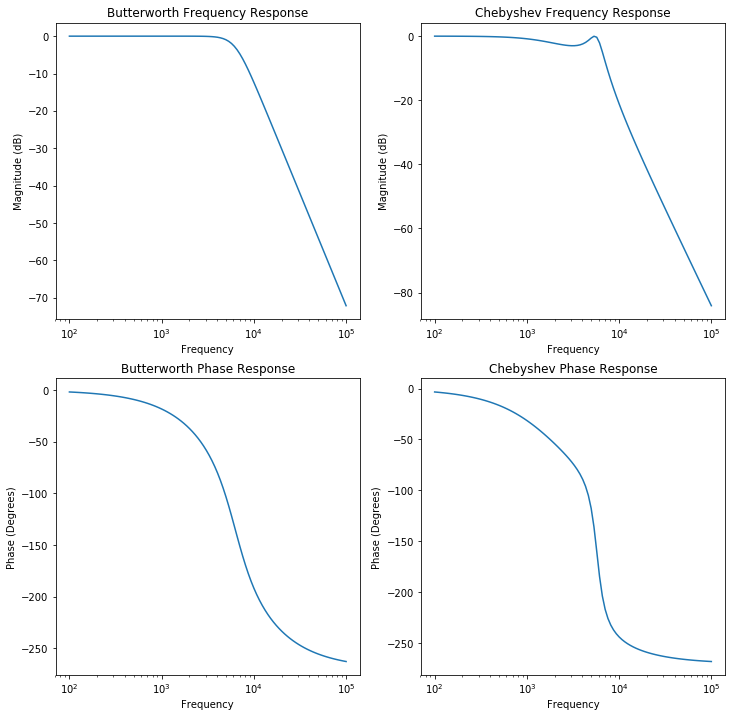

In [3]:
plt.figure(figsize=(12, 12))

# Butterworth
b, a = scipy.signal.butter(3, 1000 * 2 * scipy.pi, btype="lowpass", analog=True)
angularFreq, freqResponse, phaseResponse = scipy.signal.bode(scipy.signal.lti(b, a))

plt.subplot(2, 2, 1)
plt.semilogx(angularFreq, freqResponse)
plt.title("Butterworth Frequency Response")
plt.xlabel("Frequency")
plt.ylabel("Magnitude (dB)")

plt.subplot(2, 2, 3)
plt.semilogx(angularFreq, phaseResponse)
plt.title("Butterworth Phase Response")
plt.xlabel("Frequency")
plt.ylabel("Phase (Degrees)")

# Chebyshev
b, a = scipy.signal.cheby1(3, 3, 1000 * 2 * scipy.pi, btype="lowpass", analog=True)
angularFreq, freqResponse, phaseResponse = scipy.signal.bode(scipy.signal.lti(b, a))

plt.subplot(2, 2, 2)
plt.semilogx(angularFreq, freqResponse)
plt.title("Chebyshev Frequency Response")
plt.xlabel("Frequency")
plt.ylabel("Magnitude (dB)")

plt.subplot(2, 2, 4)
plt.semilogx(angularFreq, phaseResponse)
plt.title("Chebyshev Phase Response")
plt.xlabel("Frequency")
plt.ylabel("Phase (Degrees)")

plt.show()

In the above bode plots you can see the difference between the two filter classes, in particular the ripple that is present in the passband of the Chebyshev.

## Designing a filter

Now that we've looked at some context, we'll look at how an IIR filter is designed and implemented to meet a set of arbitrary design requirements. The steps in our example are as below. There are some steps that might sound unfamiliar, but these will be described in more detail as we work through them.

1. Gathering requirements
2. Decide on a filter class that will be best suited to your use
2. Either calculate or lookup the transfer function of the filter you've chosen
3. Convert the transfer function into a form we can describe in code by:  
    a. Performing a bilinear transform on our chosen transfer function  
    b. Using the inverse Z transform on our bilinear-transformed transfer function  
    c. Rearranging the output of the inverse Z transform to provide us with some filter coefficients
4. Write our code using the filter coefficents we just worked out

### Gathering requirements
The first thing we need to do is understand the application of our filter and the performance that is required of it.

There are several important parameters that will inform later design decisions, such as:
 - What is the frequency range we need to filter out, and how much does this range need to be attenuated?
 - What is the frequency range we need to preserve?
 - Can we tolerate ripple in the passband or stopband?
 - How sharp does the transition between the passband and stopband need to be?
 - Do we need to consider phase response or group/phase delay?
 - Should the filter apply any gain?
 
For this example we'll assume that our application specifies the following:
 - Attenuate all frequencies above 1kHZ by -18dB per octave and preserve everything below
 - No ripple in the passband or stopband
 - Phase response and phase/group delay isn't important
 - Use unity gain (1)

### Choosing a filter class
Which filter class is most appropriate for your needs depends on your design requirements. The Butterworth is normally a good place to start, but if you need a sharper cutoff and can tolerate some ripple, then a Chebyshev may be more suitable.

Our requirments would guide us towards a lowpass 3rd order Butterworth, as a Chebyshev or Elliptic filter would introduce ripple that our specification says is unacceptable. We're using a 3rd order filter as a this will give us the -18dB per octave of attenuation (a 2nd order Butterworth would provide only -12dB per octave, and a 4th order would provide -24dB per octave).

The frequency response of a lowpass Butterworth filter is defined as:  

$ \lvert H_{LP} (f) \rvert = \frac{1}{\sqrt{1 + (\frac{f}{f_c})^{2N}}} $  

If we're working in decibels, this is:  

$ \lvert H_{LP} (f) \rvert = 20log_{10}\frac{1}{\sqrt{1 + (\frac{f}{f_c})^{2N}}} $

This might look a little complicated, but it just means that the output gain for any given frequency, is dependent on only the following things:
- The frequency of the signal we're providing to the filter (f)
- The cutoff frequency of the filter ($f_c$)
- The order of the filter (N)

### Transfer functions
The starting point to implement our filter is calculating the transfer function. This is simply a function which describes the relationship between the input and output of the filter. At this stage you don't need to understand any more than this, but for those interested [this video](https://www.youtube.com/watch?v=tSprkYNkRjE) provides some more detail.

One thing to mention before starting is angular frequency ($ \omega_c $). This is just another way of measuring frequency, and a frequency in Hz is converted to angular frequency by multiplying it by $ 2\pi $

In the case of a Butterworth filter, the transfer function is found by first determining the Butterworth polynomial for the chosen order, and then dividing the chosen gain by this polynomial. (See [this page](https://en.wikipedia.org/wiki/Butterworth_filter) for more).

In this example we want the filter to have a gain of 1, and we want a 3rd order filter, so the transfer function is going to look something like:  

$ H(s) = \frac{1}{\text{3rd order Butterworth polynomial}} $

So now we need to find our Butterworth polynomial. This is given by 2 equations, one for even order filters and another for odd order filters:  

$ B_n(s) = \prod_{k=1}^{N/2} [s^2 - 2scos(\frac{2k + N - 1}{2N}\pi) + 1] $ (even order)  

$ B_n(s) = (s + 1) \prod_{k=1}^{N/2} [s^2 - 2scos(\frac{2k + N - 1}{2N}\pi) + 1] $ (odd order)  

As before N is the filter order.

You'll notice that there is no mention of the cutoff frequency in these equations, even though that would surely affect the relationship between the input and output of the filter and therefore the transfer function? That's because these are known as the normalised forms of the Butterworth polynomials, which assume an angular frequency of 1. We don't necessarily want this cutoff frequency, so we'll address this after the next step.

So after calculating our 3rd order Butterworth polynomial we get a transfer function of:  

$ H(s) = \frac{1}{(s + 1)(s^2 + s + 1)} $  

Let's multiply out the brackets now as this'll make the math a little easier later on:  

$ H(s) = \frac{1}{s^3 + 2s^2 + 2s + 1} $  

Now we need to correct that earlier assumption of $ \omega_c = 1 $. This is done by substituting s for $ \frac{s}{\omega_c} $:  

$ H(s) = \frac{1}{(\frac{s}{\omega_c})^3
                  + 2(\frac{s}{\omega_c})^2
                  + 2(\frac{s}{\omega_c})
                  + 1} $  

### Bandform transformations
In this example we want a lowpass filter so the transfer function we have now is just fine. But what if we wanted a highpass or bandpass filter? Well, this is the part of the process where we have an opportunity to make this change using a bandform transformation, so let's briefly take a detour and explore how we might do this.

This is a relatively simple process where we make some substitutions to the transfer function, to give us a new transfer function that is of the bandform that we want. I won't go through how the equations used to make the substitutions are derived, however they can be looked up [here](https://en.wikipedia.org/wiki/Prototype_filter#Bandform_transformation).

Let's go through a worked example, where we convert the lowpass transfer function that we arrived at in the previous section to the transfer function for an equivalent highpass filter.

To convert the transfer function for a lowpass filter to the transfer function for a highpass filter, we need to substitute the following equation for s in the transfer function:

$ \frac{s}{\omega_c} \rightarrow  \frac{\omega_c}{s} $

Substituting this into our transfer function gives us:

$ H(s) = \frac{1}{(\frac{\omega_c}{s})^3
                  + 2(\frac{\omega_c}{s})^2
                  + 2(\frac{\omega_c}{s})
                  + 1} $  

And that's our bandform transformation complete, we now have the transfer function of a 3rd order highpass Butterworth filter. For the rest of the process we'll use the original lowpass transfer function, but you could alternatively use the highpass transfer function that we've just created, it'd just make some of the math a little less tidy.

### Manipulating our transfer function

#### Bilinear transform
Currently our transfer function describes the analogue version of our filter, and we need to convert this to the digital equivalent. There are several ways to do this, and in this example we'll use the [bilinear transform](https://en.wikipedia.org/wiki/Bilinear_transform). This will convert our transfer function into one which we can use on discrete rather than continuous signals. [This video](https://www.youtube.com/watch?v=1HBpbagZtrc) provides an excellent overview of the process.

In short, the bilinear transform gives us the following function which we need to substitute for s:  

$ s = \frac{2}{T} \frac{z - 1}{z + 1} $

Remebering our transfer function from earler, and doing a little rearranging to separate the coefficients of s:  

$ H(s) = \frac{1}{(\frac{s}{\omega_c})^3
                  + 2(\frac{s}{\omega_c})^2
                  + 2(\frac{s}{\omega_c})
                  + 1}
       = \frac{1}{\frac{1}{\omega_c^3}s^3
                  + \frac{2}{\omega_c^2}s^2
                  + \frac{2}{\omega_c}s
                  + 1} $  

If we now substitute for s:

$ H(s) = \frac{1}{\frac{1}{\omega_c^3} (\frac{2}{T} \frac{z - 1}{z + 1})^3
         + \frac{2}{\omega_c^2}(\frac{2}{T} \frac{z - 1}{z + 1})^2
         + \frac{2}{\omega_c}(\frac{2}{T} \frac{z - 1}{z + 1}) + 1} $  

After rearranging this and substituting in T = sample period = 1/44100 we get an impractically large equation, so rather than working this out by hand we'll use the bilinear transform available in scipy. We also have to choose a cutoff frequency at this point, so we'll use the 1kHz specified by our example requirements.

*It's also worth noting that other methods of converting between analogue and digital represenations are available, and you can experiment with these by modifying the parameters provided to cont2discrete in the code below*

In [4]:
SAMPLE_PERIOD = 1 / 44100
CUTOFF_FREQ = 1000
ANGULAR_CUTOFF = 2 * scipy.pi * CUTOFF_FREQ

# Coefficients in order of descending powers of s (s^n, ..., s^1, s^0)
S_NUMERATOR = [1]
S_DENOMINATOR = [1 / ANGULAR_CUTOFF**3, 2 / ANGULAR_CUTOFF**2, 2 / ANGULAR_CUTOFF, 1]

# This returns coefficients in order of descending powers of z, starting from z^0 (eg: z^0, z^-1, z^-2)
Z_NUMERATOR, Z_DENOMINATOR, dt = scipy.signal.cont2discrete((S_NUMERATOR, S_DENOMINATOR), SAMPLE_PERIOD, "bilinear")

print(Z_NUMERATOR)
print(Z_DENOMINATOR)

[[0.00031355 0.00094066 0.00094066 0.00031355]]
[ 1.         -2.71576474  2.47050389 -0.75223074]


So this gives us:  

$ H(z) = \frac{0.00031355 + 0.00094066z^{-1} + 0.00094066z^{-2} + 0.00031355z^{-3}}
              {1 - 2.71576474z^{-1} + 2.47050389z^{-2} - 0.75223074z^{-3}} $  

#### Inverse Z transform
Now we can do the final math related step, the inverse Z transform. To do this we'll substitute the below equation into our transfer function, and solve for Y(z).

$ H(z) = \frac{Y(z)}{X{z}} $

(Where Y(z) is the output of the filter and X(z) the input.)

This rather neat piece of math will then give us an equation which describes a single sample of filter output, Y(z), using only previous input samples, X(z), and previous ouput samples Y(z):

$ \frac{Y(z)}{X{z}} = \frac{0.00031355 + 0.00094066z^{-1} + 0.00094066z^{-2} + 0.00031355z^{-3}}
                      {1 - 2.71576474z^{-1} + 2.47050389z^{-2} - 0.75223074z^{-3}} $  

Now we need to rearrange for Y(z):  

$ Y(z)(1 - 2.71576474z^{-1} + 2.47050389z^{-2} - 0.75223074z^{-3})
  = X{z}(0.00031355 + 0.00094066z^{-1} + 0.00094066z^{-2} + 0.00031355z^{-3}) $  

$ Y(z) - 2.71576474Y(z)z^{-1} + 2.47050389Y(z)z^{-2} - 0.75223074Y(z)z^{-3}
  =
  0.00031355X(z) + 0.00094066X(z)z^{-1} + 0.00094066X(z)z^{-2} + 0.00031355X(z)z^{-3} $  
  
$ Y(z)  
  =
  0.00031355X(z) + 0.00094066X(z)z^{-1} + 0.00094066X(z)z^{-2} + 0.00031355X(z)z^{-3} + 2.71576474Y(z)z^{-1} - 2.47050389Y(z)z^{-2} + 0.75223074Y(z)z^{-3} $  

And that's it! But what does it actually mean? We'll as mentioned, Y(z) is the current output sample, and X(z) is the current input sample, but importantly the negative exponent z terms represent previous samples in the signal being processed.

So in our example, this function says that to get the current **output** sample of a signal being processed, we need to sum the following:  
- the current **input** sample multiplied by 0.00031355  
- the previous **input** sample multiplied by 0.00094066  
- the **input** sample before the previous input sample multiplied by 0.00094066  
- the **input** sample before the sample before the previous input sample multiplied by 0.0.00031355  
- the previous **output** sample multiplied by 2.71576474  
- and so on ...


At this point it's also worth noting that as the order of the filter increases, so does the number of negative exponent z terms and therefore the number of previous samples which the output depends on.

As a interesting aside, the below code plots the coefficients produced by a 3th order butterworth for cutoff frequencies between 50Hz and 3500Hz.

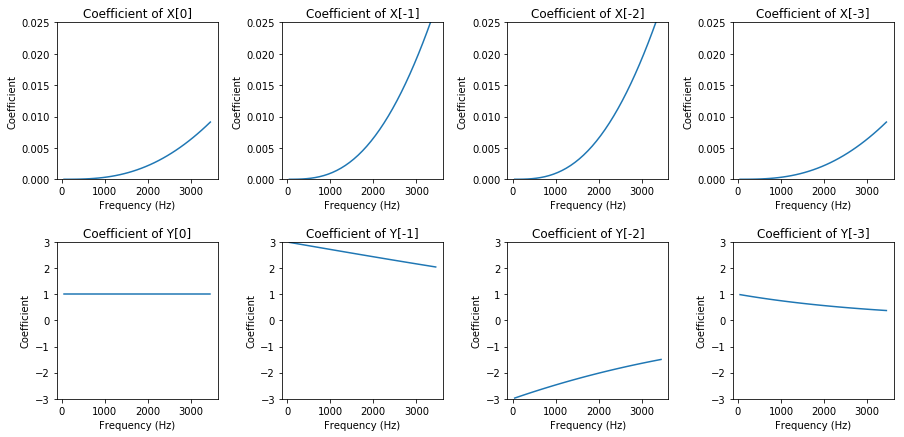

In [5]:
SAMPLE_PERIOD = 1 / 44100
CUTOFF_FREQS = np.arange(50, 3500, 100)
ANGULAR_CUTOFFS = 2 * scipy.pi * CUTOFF_FREQS

# Get our numerator and denominators
S_NUMERATOR = [1]
S_DENOMINATORS = [[1 / cutoff**3, 2 / cutoff**2, 2 / cutoff, 1] for cutoff in ANGULAR_CUTOFFS]

# Calculate the coefficients
Z_NUMERATORS, Z_DENOMINATORS = np.zeros((ANGULAR_CUTOFFS.shape[0], 4)), np.zeros((ANGULAR_CUTOFFS.shape[0], 4))
for iii, Sdenom in enumerate(S_DENOMINATORS):
    Znumer, Zdenom, _ = scipy.signal.cont2discrete((S_NUMERATOR, Sdenom), SAMPLE_PERIOD, "bilinear")
    Z_NUMERATORS[iii] = np.asarray(Znumer)
    Z_DENOMINATORS[iii] = np.asarray(Zdenom)

plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

def plotCoefficient(title, yAxis, yRange, plotNumber):
    plt.subplot(4, 4, plotNumber)
    plt.plot(CUTOFF_FREQS, yAxis)
    plt.ylim(bottom=yRange[0], top=yRange[1])
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Coefficient")

# Numerators
plotCoefficient("Coefficient of X[0]", Z_NUMERATORS[:, 0], [0, 0.025], 1)
plotCoefficient("Coefficient of X[-1]", Z_NUMERATORS[:, 1], [0, 0.025], 2)
plotCoefficient("Coefficient of X[-2]", Z_NUMERATORS[:, 2], [0, 0.025], 3)
plotCoefficient("Coefficient of X[-3]", Z_NUMERATORS[:, 3], [0, 0.025], 4)

# Denominators
plotCoefficient("Coefficient of Y[0]", Z_DENOMINATORS[:, 0], [-3, 3], 5)
plotCoefficient("Coefficient of Y[-1]", Z_DENOMINATORS[:, 1] * -1, [-3, 3], 6)
plotCoefficient("Coefficient of Y[-2]", Z_DENOMINATORS[:, 2] * -1, [-3, 3], 7)
plotCoefficient("Coefficient of Y[-3]", Z_DENOMINATORS[:, 3] * -1, [-3, 3], 8)

plt.show()

You can see that as the cutoff frequency increases the coefficients of the input samples increase, and therefore the input signal has more influence over the filter's output. Conversely, the magnitudes of the coefficents of the previous output samples decreases, giving the previous output samples less influence over the filter's output.

It's also worth noting that the coefficient of Y[0] is always 1, which makes sense as this is simply the current output.

### Writing the code

Now that we have a representation of our filter's output in a form that we can program, let's build it!

In the code sample below I've defined a function which applies the filter coefficients that we've just calculated to a buffer of samples, and some supporting code that plots the output of this.

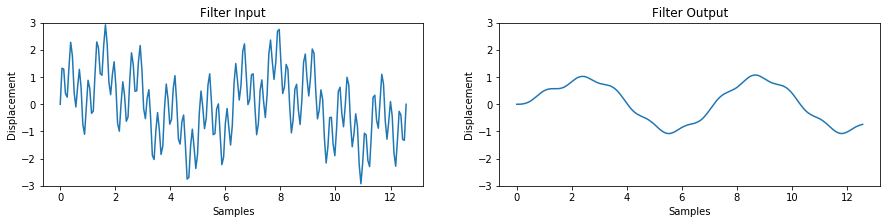

In [6]:
# Build our sine signal
NUM_SAMPLES = 200
SAMPLE_RATE = 44100
sampleRange = np.linspace(0, 4 * np.pi, NUM_SAMPLES)
buffer = np.sin(sampleRange) + np.sin(5 * sampleRange) + np.sin(20 * sampleRange)

plt.figure(figsize=(15, 3))

# Plot the input
plt.subplot(1, 2, 1)
plt.plot(sampleRange, buffer)
plt.ylim(bottom=-3, top=3)
plt.title("Filter Input")
plt.xlabel("Samples")
plt.ylabel("Displacement")

def processBuffer(buffer):
    """
    This is the code for our filter.
    We need a few if statements to make sure we don't go out of bounds at the start of the
    buffer where we don't have enough previous samples (there are better ways to handle this!)
    """
    
    output = np.zeros(buffer.shape)

    for sampleNum in range(len(buffer)):
        output[sampleNum] = 0.00031355 * buffer[sampleNum]

        if sampleNum > 0:
            output[sampleNum] += 0.00094066 * buffer[sampleNum - 1] + 2.71576474 * output[sampleNum - 1]

        if sampleNum > 1:
            output[sampleNum] += 0.00094066 * buffer[sampleNum - 2] - 2.47050389 * output[sampleNum - 2]

        if sampleNum > 2:
            output[sampleNum] += 0.00031355 * buffer[sampleNum - 3] + 0.75223074 * output[sampleNum - 3]
            
    return output
        
output = processBuffer(buffer)

# Plot the output
plt.subplot(1, 2, 2)
plt.plot(sampleRange, output)
plt.ylim(bottom=-3, top=3)
plt.title("Filter Output")
plt.xlabel("Samples")
plt.ylabel("Displacement")
plt.show()
    

## Conclusion
So that's it, we started by describing what a filter should do and how filters are characterised, then how we design and implement a digital IIR filter using the bilinear transform.

The methods described in the previous sections should work for a lot of scenarios that you might come across, however what I've presented is really only the minimum required to get you started with building your own filters, so there are a few caveats worth noting and areas that you might wish to explore further.

### Short comings of the bilinear transform
In attempting to map an analogue filter to a digital equivalent, the bilinear transform provides only an approximation and doesn't preserve all of the characteristics of the continuous filter that we started with. In particular the amplitude response and phase response of a discrete filter will not entirely match that of the continuous filter. Depending on how important this is to your use case you may need to use [frequency prewarping](https://en.wikipedia.org/wiki/Bilinear_transform#Frequency_warping) to migitgate it, which we may cover in a later notebook.

Another noteworthy characteristic that is not accurately captured by the bilinear transform is the group delay of a filter. This is particularly important if you wish to produce a digital implementation of a bessel filter, as one of its key features that you might have chosen a bessel for is its maximally flat group delay. If you require a digital filter with linear phase response or maximally flat group delay, you may wish to look at using a Thiran filter or an FIR filter.

## Further Reading

### Videos
[What is Butterworth filter Approximation](https://www.youtube.com/watch?v=evbcE5_IHaM)  
[Problem no.1 on Butterworth Filter Design](https://www.youtube.com/watch?v=CavMvvL6Pno)  
[Digital Filters Part 1](https://www.youtube.com/watch?v=loHy8v9A8LY)  
[Digital Filters Part 2](https://www.youtube.com/watch?v=biOqM5BRTDs)  
[Signal Processing - 14 Bilinear Transform - Explained](https://www.youtube.com/watch?v=1HBpbagZtrc)  
[Signal Processing - 18 Filter Transformation - Real World Example](https://www.youtube.com/watch?v=WJ7WeKgdcQw)  
[What is meant by Infinite Impulse Response (IIR) System and Finite Impulse Response (FIR) System](https://www.youtube.com/watch?v=Q9JAfeJyO74)  
[Digital IIR Filter, Ivan Cohen](https://www.youtube.com/watch?v=esjHXGPyrhg)  

### Texts
[The Art of VA Filter Design](https://www.native-instruments.com/fileadmin/ni_media/downloads/pdf/VAFilterDesign_1.1.1.pdf)  
[Bilinear Transform](https://en.wikipedia.org/wiki/Bilinear_transform)  
[Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter)  
[Important filter classes](https://en.wikipedia.org/wiki/Network_synthesis_filters#Important_filter_classes)  
